In [1]:
# imported dependencies
import pennylane as qml
from itertools import product
import numpy as np
import random

In [2]:
def generate_density_matrix():
    # Use Hadamard for density matrix
    state = np.array([0.5, 0, 0.5, 0, 0, 0.5, 0, 0.5])
    
    # generate the density matrix
    rho = np.outer(state, np.conj(state).T)
    return rho

In [3]:
# Set up Unitary matricies U
U1 = qml.PauliZ(0) @ qml.Identity(1) @ qml.Identity(2)
U1 = U1.matrix()
U2 = qml.Identity(0) @ qml.PauliZ(1) @ qml.Identity(2)
U2 = U2.matrix()
U3 = qml.Identity(0) @ qml.Identity(1) @ qml.PauliZ(2)
U3 = U3.matrix()
U_list = [U1, U2, U3]

# Set up generators and stabilizer list 
G1 = (qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)).matrix()
G2 = (qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2)).matrix()
I = (qml.Identity(0) @ qml.Identity(1) @ qml.Identity(2)).matrix()
S = [G1, G2, G1 @ G2, I]

<br>

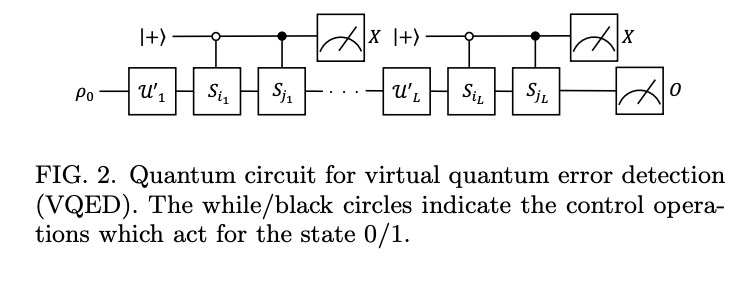

In [15]:
L = len(U_list)
rho_naught = generate_density_matrix()
estimation_wires = list(range(0, L))
target_wires = list(range(L, L+3))

dev = qml.device("default.mixed", wires=(len(estimation_wires+target_wires)))

@qml.qnode(dev)
def VQED(stabilizer_list, unitary_list):
    # stabilizer list is same len as estimation wires

    # initialize target and estimation wires
    qml.QubitDensityMatrix(rho_naught, wires=target_wires)   
    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    for l in estimation_wires:
        # get the 3 unitary matries 
        s_i = stabilizer_list[l][0]
        s_j = stabilizer_list[l][1]
        U = unitary_list[l]
    
        # apply the gates 
        qml.QubitUnitary(U, wires=target_wires)
        qml.BitFlip(0.5, wires=estimation_wires[0])
        qml.ControlledQubitUnitary(s_i, control_wires=estimation_wires[l], wires=target_wires, control_values="0")
        qml.ControlledQubitUnitary(s_j, control_wires=estimation_wires[l], wires=target_wires, control_values="1")
    prod = qml.PauliX(estimation_wires[0])
    for wire in range(1,len(estimation_wires)):
        prod = prod @ qml.PauliX(estimation_wires[wire])
    return (qml.expval(prod), 
            qml.expval(qml.Hadamard(target_wires[0]) @ qml.PauliX(target_wires[1]) @ qml.Hadamard(target_wires[2])))


<br>

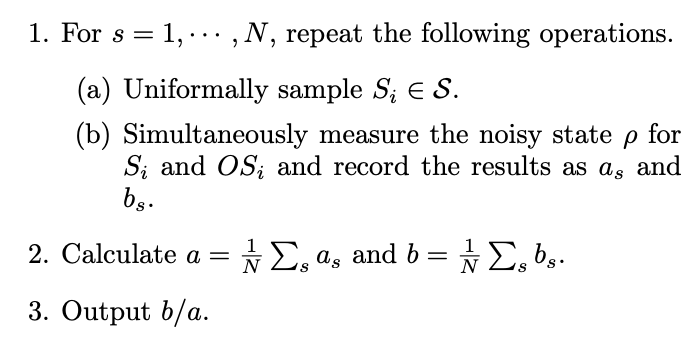


In [16]:
a = 0
b = 0
N = 4
for s in range(N):
    s_sample = [random.sample(S,2),random.sample(S,2),random.sample(S,2)]
    a_s, O_measurement = VQED(s_sample, U_list)
    b_s = a_s * O_measurement
    a += a_s
    b += b_s

a = a/N
b = b/N

print("a:")
print(a)

print("b:")
print(b)

print("b/a:")
print(b/a)

a:
0.0
b:
0.0
b/a:
nan


C:\Users\Marco\AppData\Local\Temp\ipykernel_18568\3955469407.py:21: RuntimeWarning: invalid value encountered in double_scalars
  print(b/a)
